# Ground reaction curve for tunnel design in Python

## Introduction

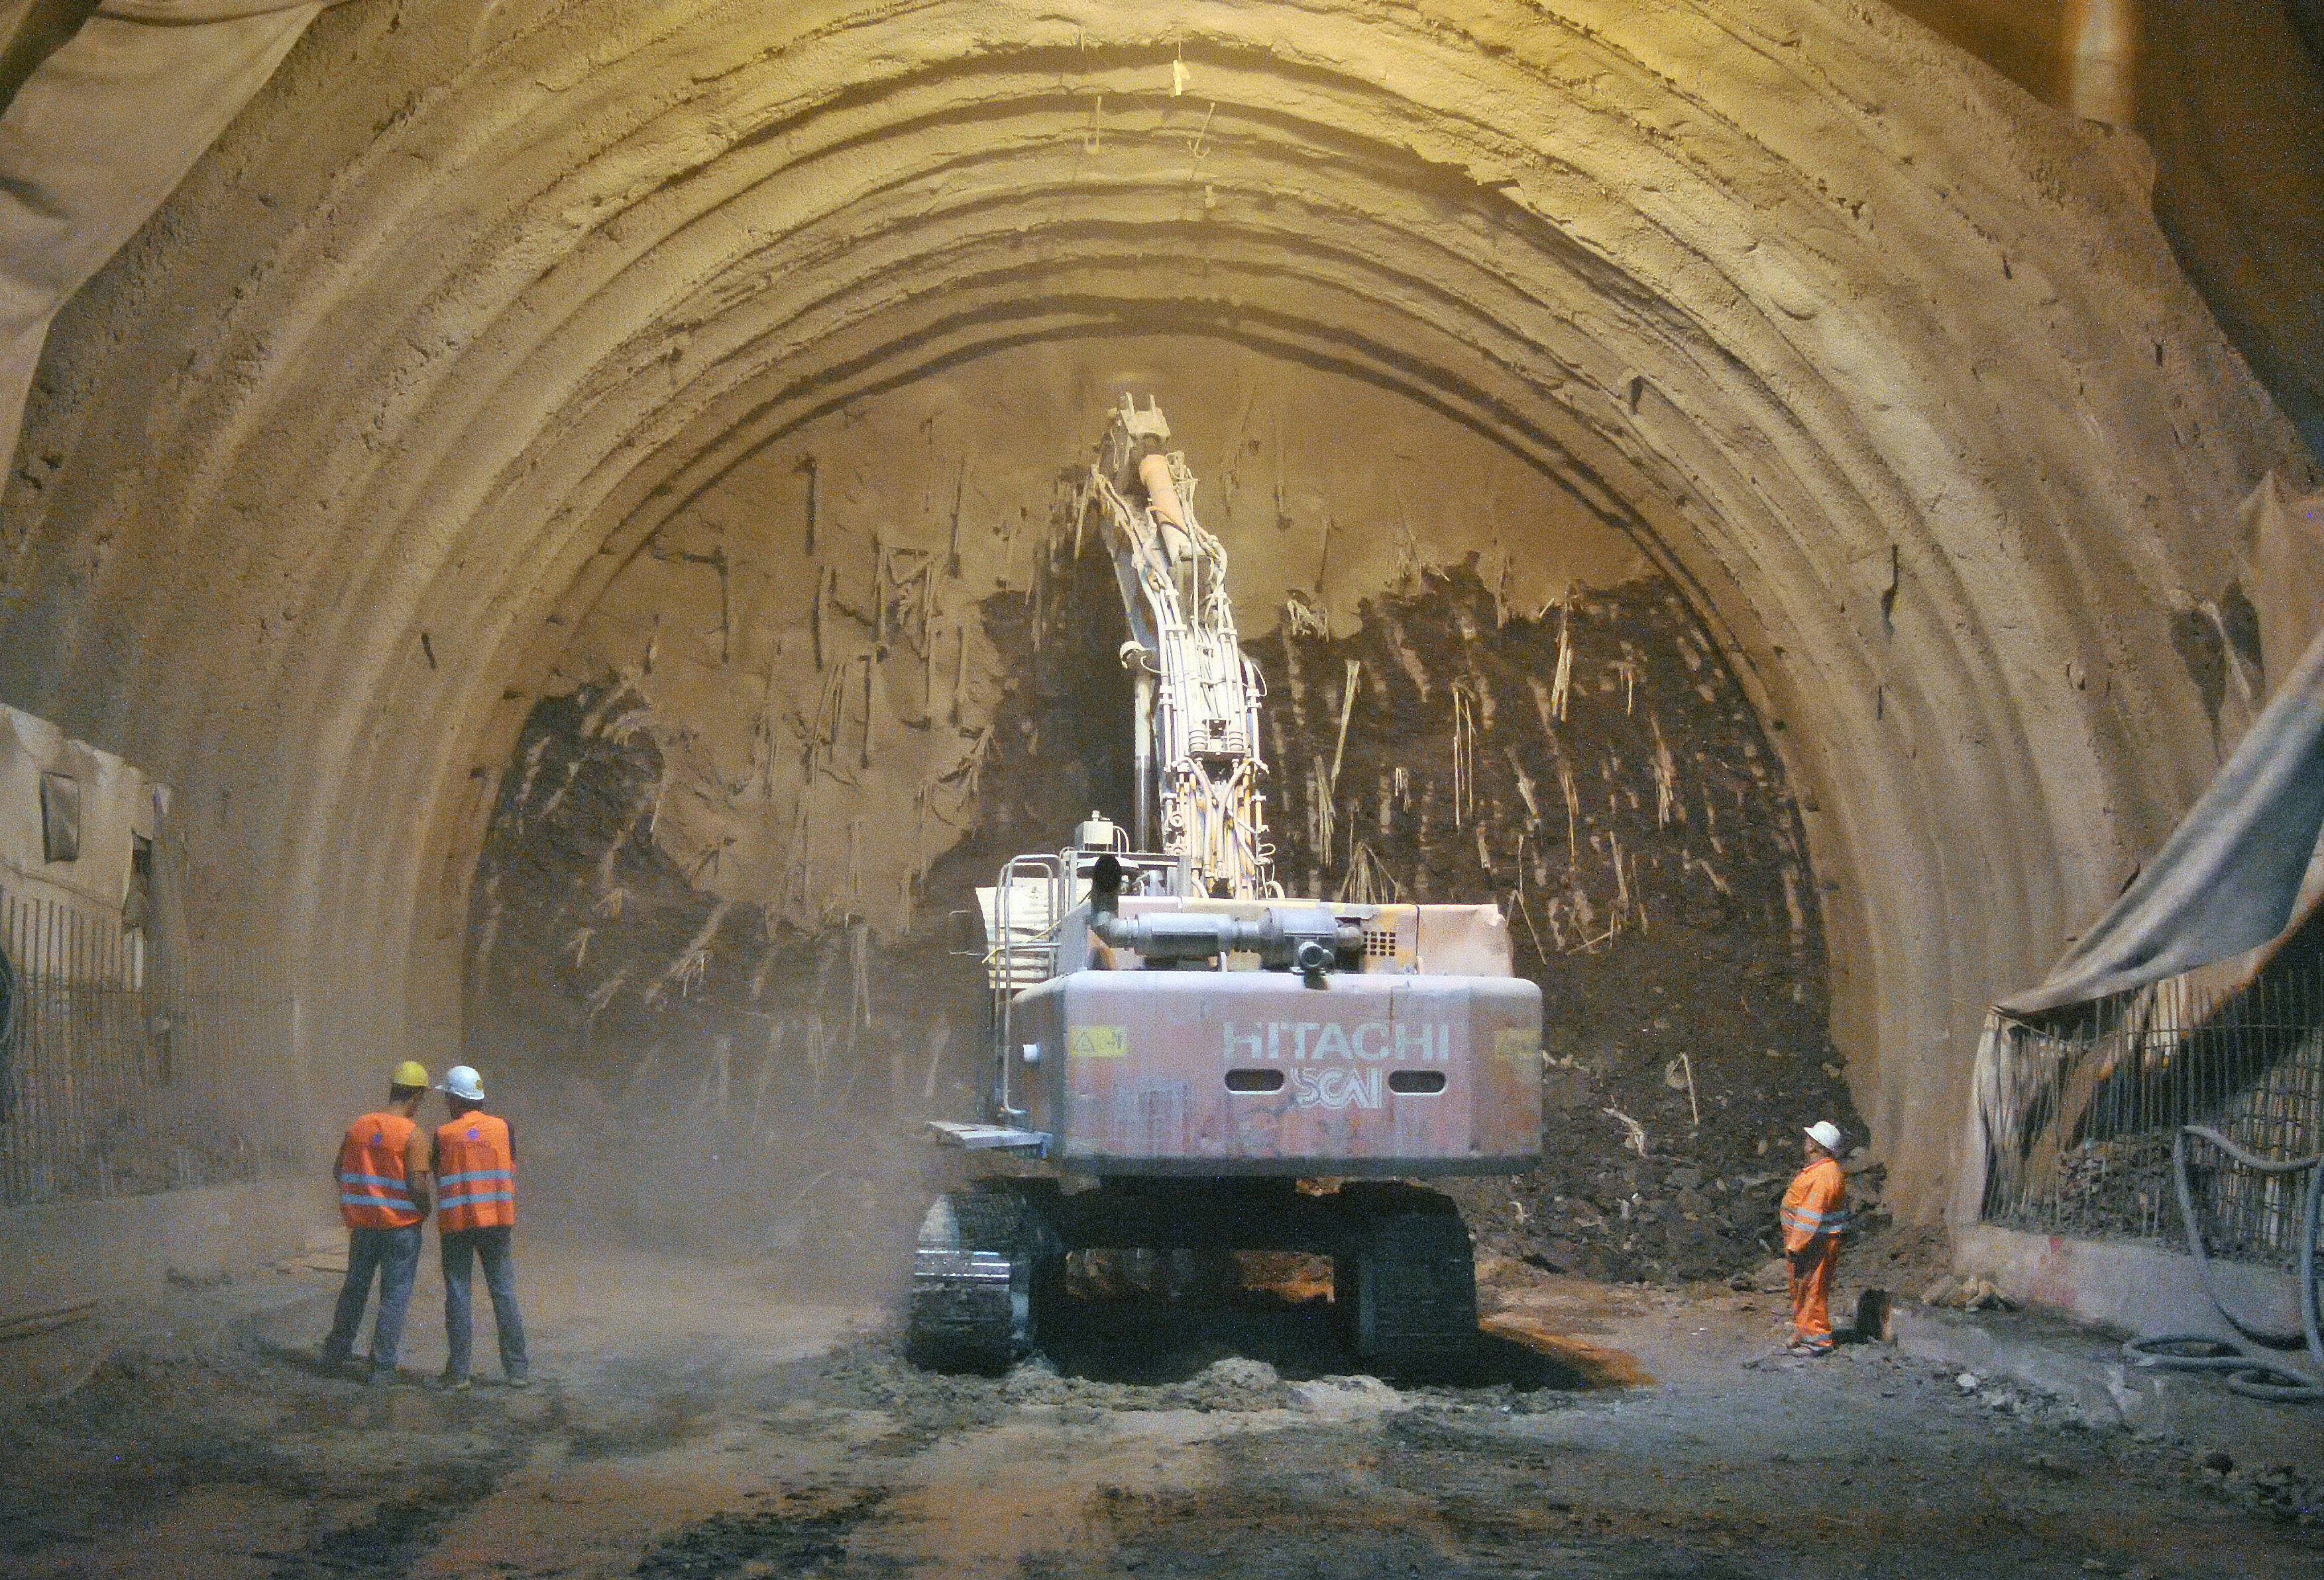

Designing tunnel support was for many years considered too complex an analytical engineering process. The design was simply based on repeating construction methods that proved to be successful.
In the middle of the 70s approximately, the "Ground Support Reaction curve" method (or "Carachteristic Line Method") stepped into engineering practice.
The method relied on a very easy concept to transform a three-dimensional problem as the advancing of an excavated tunnel is, into a 2D plain strain deformation problem.
The method relies on a simple yet strong concept, the advancing of the excavation face and the increasing of cumulated deformation in the tunnel is simulated by a relaxation parameter $\lambda$ applied to the in-situ pressure $p_0$ as follows:

<h3><center>$p_i = p_0(1-\lambda)$<center><h3>

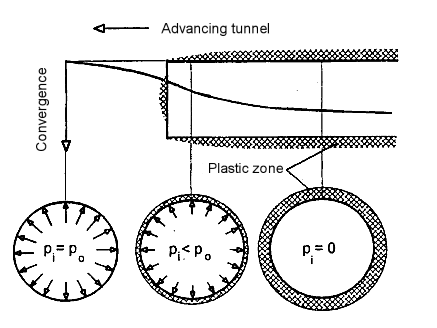

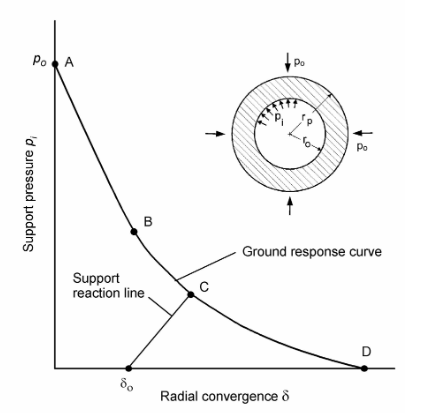

Here some packages we will use to develop the code:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The ground response curve construction

The method for the characteristic curve determination presented in this article is very simple and relies on the formula proposed by Amberg Lombardi.
Let's see the main ingredient of this recipe:

- The method assumes an elastic perfectly plastic behavior of the rock mass
- As with every elastic-perfectly plastic method, a "yield point" should be determined. For this particular method we are considering a Mohr-Coulomb failure i.e. $\phi$ and $c$
- Everything that remains inside the yielding point is the elastic domain and can be easily determined with the elasticity theory. Nice, linea, reversible.
- Everything outside the yielding point shall be computed assuming a plastic behavior. Tricky, non-linear, non-reversible.

I just trying to give you some flavor about the main topics involved, in the next section I will go through the formula I used without going into many details I the underlying theory. For those who are more interested in the theory too, I will let some recommended readings in the "Reference" section.

### Elastic behavior

The elastic part of our ground reaction curve is determined as follows:

<h3><center>$u_{el} = \frac{1+\nu}{E_p} (p_0 - p_i) a$ <center><h3>

Where:

- $u_{el}$ is the tunnel convergence  
- $a$ is the tunnel radius    
- $\nu$ the Poisson's ration
- $E_p$ the Young's Modulus at peak (Amberg-Lombardi method takes into account the softening behaviour of the rock mass)
    
Let's put this in code lines:

In [16]:
def u_el_calc(p0,nu,pi,Ep,a):
    
    ep = Ep*1000
    u_el = (1+nu)/ep*(p0-pi)*a*100 #cm
    
    return u_el

### Yielding point

As previously said, we are considering a Mohr-Coulomb failure. I assume the topic is known so I will just discuss its implication in this specific topic. 
With varying $p_i$ we will reach a point where the stress inside the rock mass will reach its failure limit. The failure limit in the rock mass is expanding with $p_i$ decreasing: at a certain distance from the tunnel our material will be in the elastic field. This distance is expressed by the "Plastic Radius" $R_p$: 

<h3><center> $R_p = a [\frac{(p_0+c_r\cot{\phi_r})-(p_0+c_p\cot{\phi_p})\sin{\phi_p}}{p_i +c_r\cot{\phi_r}}]^{\frac{1}{N_r-1}}$ <center><h3>

In [17]:
def cot(j):
    
    _cot_ = 1/np.tan(j)
    
    return _cot_

def Rp_calc(pi,p0,fi_r,fi_p,cr,cp,Nr,a):
    
    Rp = a*((p0+cr*cot(fi_r)-(p0+cp*cot(fi_p))*np.sin(fi_p))/(pi+cp*cot(fi_p)))**(1/(Nr-1))
    
    return Rp

Where:

- $\phi_p$,$\phi_r$,$c_p$,$c_r$ are respectively the friction angle at the cohesion, at peak and residual
- $N_r = (1+\sin{\phi_r})/(1-\sin{\phi_r})$


At what pressure we reach the yielding point? When $R_p = a$. Inverting the previous formula we get:

<h3><center> $p_{cr} = \frac{2(p_0-c_p\sqrt{N_p})}{1+N_p}$<center><h3>

- $N_p = (1+\sin{\phi_p})/(1-\sin{\phi_p})$

In [18]:
def p_cr_calc(p0,cp,Np):
    
    p_cr  = 2*(p0-cp*np.sqrt(Np))/(1+Np) #kPa
    
    return p_cr

### Plastic behaviour

The evolution of the displacement with the changing pressure is expressed by the following (tricky) formula:

<h3><center> $u_{pl} = \frac{1+\nu}{E_p}(p_0+c_p\cot{\phi_p})\sin{\phi_p}+\frac{1+\nu}{E_r}[(p_0+c_r\cot{\phi_r})(\frac{R_p^2}{a}-a)-\frac{p_i +c_r\cot{\phi_r}}{a^{N_r-1}}(\frac{R^{N_r+1}}{a}-a^{N_r})]$ <center><h3>

In [19]:
def u_pl_calc(Rp,pi,Ep,Er,p0,fi_p,cp,fi_r,cr,nu,Np,Nr,a):
    
    ep = Ep*1000 #kPa
    er = Er*1000 #kPa
    
    sum_1 = (1+nu)/ep*(p0+cp*cot(fi_p))*np.sin(fi_p)*(Rp**2)/a
    sum_2 = (1+nu)/er*(1-2*nu)*((p0+cr*cot(fi_r))*((Rp**2)/a-a)-(pi+cr*cot(fi_r))/(a**(Nr-1))*((Rp**(Nr+1))/a-a**Nr))
    
    u_pl = (sum_1+sum_2)*100 #cm
    
    return u_pl

### Solving the problem

As can be seen, we are facing a nonlinear problem where a single value of pressure shall satisfy both the equation of the plastic radius and the equation of the plastic displacement:
- A set of different pressure values is prepared, from in-situ pressure to 0 (nonsupported excavation);
for each pressure, I computed the value of $\lambda$ and I checked the pressure if it was above or not the critical pressure;
- If it is above, no problem elastic formula;
- If it is below, I compute the formula for the plastic radius and the plastic displacement

In [20]:
def groun_reaction_calc(fi_p,fi_r,Np,Nr,cp,cr,nu,a,Ep,Er,p0):
    # pressure lists
    p = np.arange(p0,0,-1)
    
    # critical pressure
    p_cr = p_cr_calc(p0,cp,Np)
    print("Critical pressure [kPa] = ",float(round(p_cr,0)))
    
    data = []
    for pi in p:
        
        l = 1-pi/p0
        
        Rp = np.nan
        
        if pi>=p_cr:
            # elastic settlement calculation
            u = u_el_calc(p0,nu,pi,Ep,a)
            
        else:
            
            # plastic radius calculation
            Rp =  Rp_calc(pi,p0,fi_r,fi_p,cr,cp,Nr,a)
            
            #plastic settlement calculation
            u = u_pl_calc(Rp,pi,Ep,Er,p0,fi_p,cp,fi_r,cr,nu,Np,Nr,a)

        data.append([pi,l,u,Rp])
        
        df = pd.DataFrame(data = data, columns = ['p [kPa]','$\lambda$ [-]','u [cm]','Rp [m]'])
        
    return df

Let's define the input of our rock mass:

In [21]:
fi_p = 30 # friction angle at peak
fi_p = np.deg2rad(fi_p)
fi_r = 30 # friction angle residual
fi_r = np.deg2rad(fi_r) 
Np = (1+np.sin(fi_p))/(1-np.sin(fi_p))
Nr = (1+np.sin(fi_r))/(1-np.sin(fi_r))
cp  = 5  #kPa - cohesion at peak
cr  = 5  #kPa - cohesion at residual
g  = 19   #kN/m3 - unit weigth of the rock mass
H  = 12   #m - overburden
nu = 0.25 # - Poisson ration
a = 7.5    #raggio galleria
Ep = 250 #MPa - Young modulus at peak
Er = 75 #MPa  - Young modulus residual
p0    = g*H

In [22]:
df = groun_reaction_calc(fi_p,fi_r,Np,Nr,cp,cr,nu,a,Ep,Er,p0)

Critical pressure [kPa] =  110.0


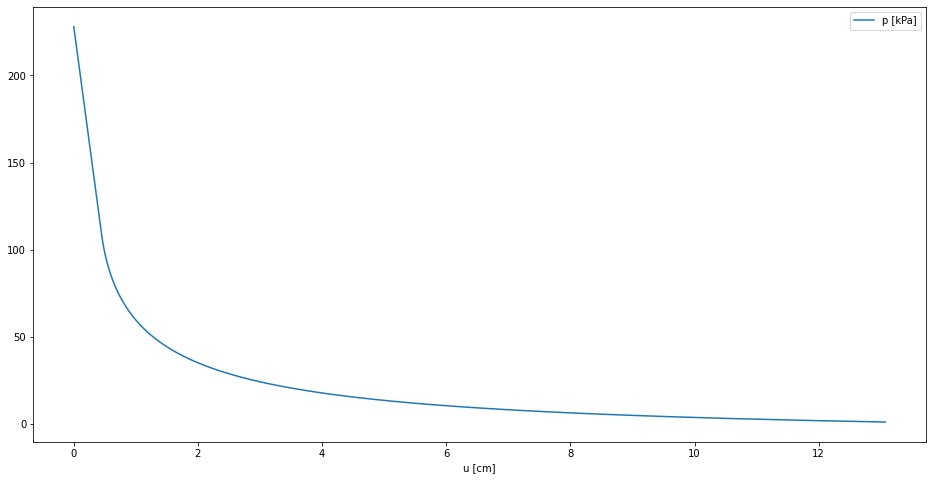

In [23]:
fig,ax = plt.subplots(figsize=(16,8))
df.plot(x= 'u [cm]',y = 'p [kPa]',ax = ax)
plt.show()

## Longitudinal displacement profile

The last ingredient in our model is to define the "Longitudinal Displacement Profile" i.e. the evolution of the displacement as a function of the distance from the tunnel face.
Why is it important to know this parameter? To be used for design purposes, we have to link the characteristic line with the distances at which our tunnel supports are installed. 
For the present article, we are going to consider the formulation by Panet (1995). As one can get from what has been written so far, there is a significant difference if the constitutive model of the soil is considered elastic or elasto-plastic. According to Panet, the longitudinal displacement profile of an elasto-plastic medium is equal to the elastic one with a homothetic transformation of $\xi$ parameter.

<h3><center>$u_{pl}(x) = \frac{1}{\xi}[a_0 +(1+a_0)a(x)]\frac{2(1+\nu)}{E_p}p_0$<center><h3>

<h3><center>$a(x) = 1-[\frac{ma}{ma+x\xi}]$<center><h3>

Where:
 - $x$ is the distance from tunnel face
 - $a_0$ is 0.25
 - $m$ is 0.75

$\xi$ is expressed as follows:

<h3><center>$\frac{1}{\xi} = \lambda_e[\frac{R_p}{a}]^2$<center><h3>

- $R_p$ is the maximum plastic radius (i.e. $p_i = 0$)
- $\lambda_e = 1-p_{cr}/p_0$

In [24]:
Rp_inf = Rp_calc(0,p0,fi_r,fi_p,cr,cp,Nr,a)
pcr = p_cr_calc(p0,cp,Np)
le = 1-pcr/p0
inv_xi = le*(Rp_inf/a)**2

In [25]:
# distance from the tunnel face
X = np.arange(0,10*a)

m  = 0.75
a0 = 0.25

upl_list = []
lambda_x = []
for x in X:
    a_x = 1-(m*a/(m*a+x*1/inv_xi))
    
    # plastic convergence
    
    upl_x = inv_xi*(a0+(1+a0)*a_x)*2*(1+nu)/(Ep*1000)*p0*100
    upl_list.append(upl_x)
    lambda_x.append(np.interp(upl_x,df['u [cm]'],df['$\lambda$ [-]']))
                    
df_x = pd.DataFrame({'x [m]':X,'u [cm]':upl_list,'$\lambda$ [-]':lambda_x})

Printing the results:

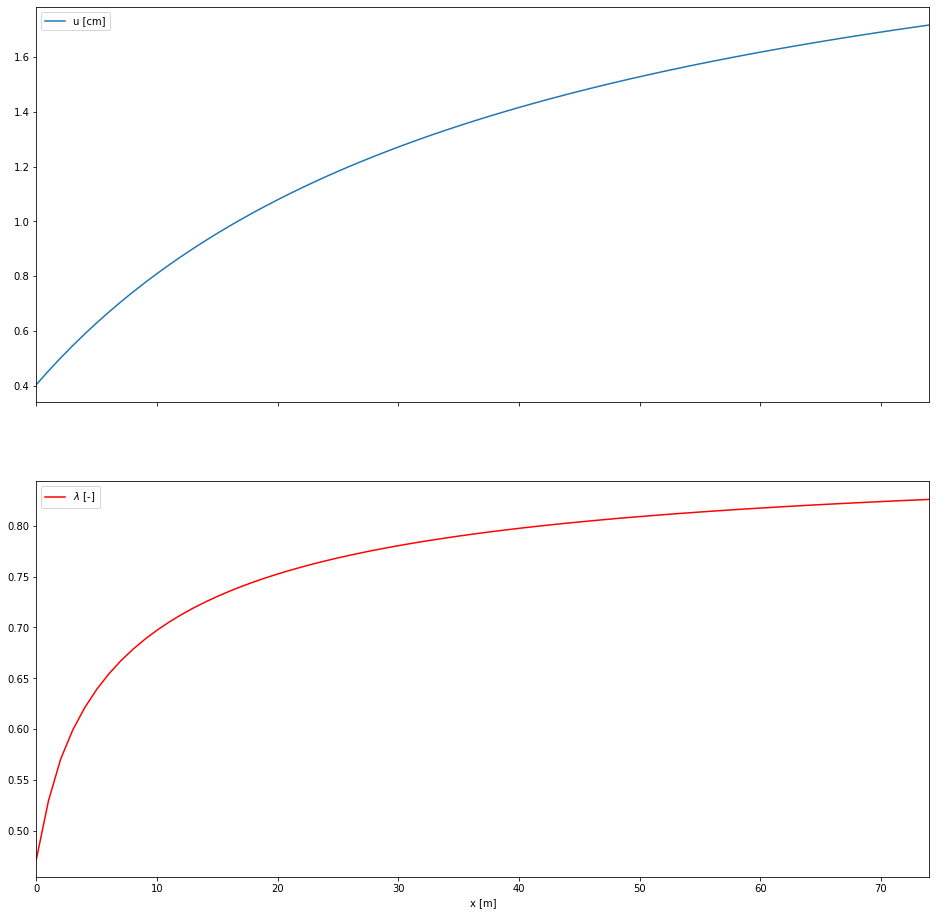

In [26]:
fig,ax = plt.subplots(2,1,figsize=(16,16),sharex = True)

df_x.plot(x = 'x [m]',y = 'u [cm]', ax = ax[0])
df_x.plot(x = 'x [m]',y = '$\lambda$ [-]', ax = ax[1],color = 'red')
ax[0].set_xlim(0,max(X))


plt.show()

## Method application in common practice in combination with PLAXIS

The chapter aims to provide a quick overview of how to apply this methodology to FEM calculation. The topic is so vast that this should be considered a simple introduction to the problem.

In the modern days, the spread of FEM software had taken over the use of analytical solutions in design practice. The possibility to take into account complex stratigraphy in conjunction with non-linear soil and rocks models is an advantage. As said in the incipit of the article, the ground reaction method aims to transform a 3D problem into a 2D problem. These results are helpful also dealing with FEM models, having the possibility to switch to a simpler model compared to 3D calculations.

In the following, I will try to explain the methodology I use for tunnel design with PLAXIS and the ground reaction curve method.

![PLAXIS.png](PLAXIS.png)

For those who don't know, PLAXIS is a widespread FEM software developed at Delft Technical University and recently acquired by Bentley. Personally, I appreciate the presence of a Python API that enables interesting automation possibilities.

We will deal with two topics:

 - Calibration of the ground reaction curves
 - Simulation of the construction sequence

### Calibration of the ground reaction curve

This is not a strictly required passage but in most cases is required in some cases for examples:

 - presence of a complex stratigraphy (layered media)
 - consolidation works around the tunnel excavation profiles
 - shallow conditions (in theory not reaction curve not applicable)
 
 and other non-canonic situations.
 
 PLAXIS uses the $M_{stage}$ parameter to track the evolution of the computations. The parameter varies from 0 to 1. To perform the calibration we run in PLAXIS a "Calibration stage" creating the excavation without inserting the tunnel support. In this condition is easy to assume that at the beginning of the calculation we have the geostatic pressure and at its end, the pressure is 0, this yields the following:

<h3><center>$M_{stage} = 1-\frac{p_i}{p_0} = \lambda$<center><h3>

Positioning a monitoring point on the top of the tunnel support we can monitor the displacement versus the increase of $M_{stage}$. We will fix the parameter of our ground reaction curve formulation to match the result of the PLAXIS calculation. In the following an example is taken from a calculation, I stored the value of total displacement and of $M_{stage}$ in a .csv file.

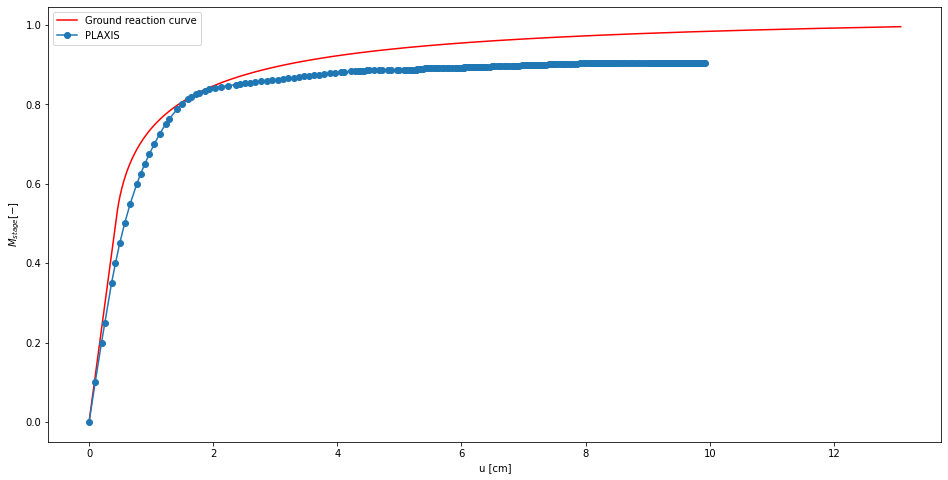

In [27]:
df_cal = pd.read_csv('calibration.csv')

fig,ax = plt.subplots(figsize=(16,8))
df.plot(x = 'u [cm]',y = '$\lambda$ [-]',ax = ax, color = 'red',label = 'Ground reaction curve')
df_cal.plot(x= 'u_top [cm]',y = 'Mstage [-]',ax = ax,marker = 'o',label = 'PLAXIS')

ax.set_xlabel('u [cm]')
ax.set_ylabel('$M_{stage} [-]$')

plt.show()

### Simulation of the construction sequence

Without going into detail on how the construction sequence is designed, usually, especially in excavation with the traditional method, the tunnel support is realised in different steps at different distances from the tunnel face. Here's in the following a brief example:

 - at 1 m distance, the realisation of the temporary support 
 - at 10 m distance realisation of the reverse arch
 - at 30 m realisations of the definitive support
 
For the scope of the present article, it is worth mentioning that in each construction step a different value of $\lambda$ is selected. This is done considering the longitudinal displacment profile:

In [28]:
# reference distances of the construction stages
dist = [1,10,30]
l_target = []

for d in dist:
    l_d = np.interp(d,df_x['x [m]'],df_x['$\lambda$ [-]'])
    l_target.append(l_d)

df_out = pd.DataFrame({'Distance from tunnel face [m]':dist,'$\lambda$ [-]':l_target})
display(df_out)

,Distance from tunnel face [m],$\lambda$ [-]
0,1,0.529920
1,10,0.697388
2,30,0.780347


The value of $\lambda$ can be then inserted as $M_{stage}$ value in PLAXIS to simulate the construction sequence.

## Conclusions

An introduction to the ground reaction curve method and its implementation in Python has been shown. The topic is so vast that this brief article can cover just a small fraction of its complexity. However, hopefully, this notebook can be used as a tool in the design practice (the code has been validated with "Rocsupport" software by Rocscience).